**Botflow**  is programming framework  built for createing fast data pipeline. 
This tutorial is a sample for analyse  Python book price distrubution with amazon book search result . And the tutorial dose not require extra tools and make you leave this page.

more information can be found in project home page:

    https://github.com/kkyon/botflow


The package you need to install 

```pip3 instll -U botflow```

update tonado to 4.5.3 because  jupyter asyncio support issue.


```pip3 install tornado==4.5.3```

and you should have baic knowlege with html and beautiful soup.


## All Steps  
1. Donwloads the serach result page (html) and get the book item html
2. parse the price ,book title,images src
1. filter out spam item
3. create pandas dataframe from the prices .And draw the hist 


### Step 1. Create download pipe.

Make amazon book search with keyword *Python* in your chrome. You can get the search result page url :

```https://www.amazon.com/s/ref=sr_pg_2?fst=p90x%3A1&rh=n%3A283155%2Ck%3Apython&page=2&d=1&keywords=python&ie=UTF8&qid=1536905092```

We can fingure the page no and keyword word in the url . In this tutorial we only replace page no  with variable . You can try change the search keywords later.
```python 

lambda p:f"https://www.amazon.com/s/ref=sr_pg_{p}?fst=p90x%3A1&page={p}&rh=n%3A283155%2Ck%3Apython&keywords=python&ie=UTF8&qid=1536500367",

```

And with inspect the html ,we can find book item is under *li* tage . get all tag with soup api .*find_all*. 
It also return many unnecceary items .Don't worry about this .will clean it later.

Let's get start with only one page. We can easy fetch more page just change run param.

In [1]:
from botflow import *
p_download=Pipe(
    
    lambda p:f"https://www.amazon.com/s/ref=sr_pg_{p}?fst=p90x%3A1&page={p}&rh=n%3A283155%2Ck%3Apython&keywords=python&ie=UTF8&qid=1536500367",
    HttpLoader(), #download the page

    lambda r:r.soup.find_all("li"),
    Flat()  #we don't need keep the hierarchy of page no. 
)

lis=p_download.run(1) #get first page
#lis=p.run(range(1,10)) get top 10 pages items
print(len(lis))



2018-09-14 14:59:08,459 root         INFO:pipe_4470375312 ready to exit


175


We got many items now. let's  pick one and see inside. It is actually a Html Tag . html code seem messy .How can first price infrom from it?

In [2]:
lis[1]

<li class="s-result-item celwidget AdHolder" data-asin="1788295269" id="result_0"><div class="s-item-container"><div class="a-fixed-left-grid"><div class="a-fixed-left-grid-inner" style="padding-left:218px"><div class="a-fixed-left-grid-col a-col-left" style="width:218px;margin-left:-218px;float:left;"><div class="a-row"><div aria-hidden="true" class="a-column a-span12 a-text-center"><a class="a-link-normal a-text-normal" href="/gp/slredirect/picassoRedirect.html/ref=pa_sp_atf_stripbooks_sr_pg1_1?ie=UTF8&amp;adId=A04794103EZM52VSV07ZR&amp;url=https%3A%2F%2Fwww.amazon.com%2FMatplotlib-2-x-Example-Multi-dimensional-charts%2Fdp%2F1788295269%2Fref%3Dsr_1_1_sspa%2F136-9982183-6544141%3Fs%3Dbooks%26ie%3DUTF8%26qid%3D1536908344%26sr%3D1-1-spons%26keywords%3Dpython%26psc%3D1&amp;qualifier=1536908344&amp;id=88207326666658&amp;widgetName=sp_atf"><img alt="Matplotlib 2.x By Example: Multi-dimensional charts, graphs, and plots in Python" class="s-access-image cfMarker" data-search-image-load="" he

## Step2: Parse book item (price,title,image)

Ok .Let's us  play magic with jupyter book ,print out the html visually .and will inspect the code whitout leave this page. 

In [3]:
from IPython.core.display import display, HTML
display(HTML(str(lis[1])))

With chrome inspect (right click menu > inspect ) the intresting element of the above Html block.
    it is easy to find out the tage anem with developer windows right side:
 
```
    images : with tag imge ,inside A link
    price : with css class span.a-offscreen and it is child of A link
    title: with tag h2 ,inside  A link
```

We can build pipes for parsing price, image,title separatly . 
Remenber ,test with only item firstly .If you feel it is ok we can run it will full list.



In [4]:
p_get_img_src=Pipe(lambda t:t.select("a img"),lambda t:t['src'])
p_get_img_src.run(lis[1])

2018-09-14 14:59:10,521 root         INFO:pipe_4514098648 ready to exit


'https://images-na.ssl-images-amazon.com/images/I/410gNSSY-+L._AC_US218_.jpg'

In [5]:
p_get_title=Pipe(lambda t:t.select("a h2"),lambda t:t.get_text())
p_get_title.run(lis[1])

2018-09-14 14:59:12,536 root         INFO:pipe_4489890280 ready to exit


'[Sponsored]Matplotlib 2.x By Example: Multi-dimensional charts, graphs, and plots in Python'

In [6]:

p_get_price=Pipe(lambda t:t.select("a > span.a-offscreen"),lambda t:t.get_text())
p_get_price.run(lis[1])

2018-09-14 14:59:14,550 root         INFO:pipe_4514098200 ready to exit


'$44.99'

In [7]:
p_get_price.Map(lambda x:float(x.replace("$",'')))
p_get_price.run(lis[1])

2018-09-14 14:59:16,563 root         INFO:pipe_4514098200 ready to exit


44.99

 We created the imge,title,price parser pipes. now need to combine the results together. Zip operator is design for this purpose . it will combine muliti pipe resul to a list. 




In [8]:
item_parse=Pipe(Zip(p_get_price,p_get_title,p_get_img_src))
item_parse.run(lis[1])

2018-09-14 14:59:18,577 root         INFO:pipe_4514224448 ready to exit


[44.99,
 '[Sponsored]Matplotlib 2.x By Example: Multi-dimensional charts, graphs, and plots in Python',
 'https://images-na.ssl-images-amazon.com/images/I/410gNSSY-+L._AC_US218_.jpg']

Now we run the p_item_parse with full list. Actully there is now differenc from runnning one item. 


In [9]:
item_parse=Pipe(Zip(p_get_price,p_get_title,p_get_img_src))
item_parse.run(lis)

2018-09-14 14:59:20,596 root         INFO:pipe_4514222768 ready to exit


[[None, None, None],
 [44.99,
  '[Sponsored]Matplotlib 2.x By Example: Multi-dimensional charts, graphs, and plots in Python',
  'https://images-na.ssl-images-amazon.com/images/I/410gNSSY-+L._AC_US218_.jpg'],
 [None,
  "Amazon's Timothy C. Needham Page",
  'https://m.media-amazon.com/images/G/01/nav2/images/tc/authors/tc_author-pages._AA115_.png'],
 [34.99,
  '[Sponsored]SciPy Recipes: A cookbook with over 110 proven recipes for performing mathematical and scientific computations',
  'https://images-na.ssl-images-amazon.com/images/I/517etmpLAwL._AC_US218_.jpg'],
 [27.16,
  'Python Crash Course: A Hands-On, Project-Based Introduction to Programming',
  'https://images-na.ssl-images-amazon.com/images/I/51F48HFHq6L._AC_US218_.jpg'],
 [None, None, None],
 [31.24,
  'Learning Python, 5th Edition',
  'https://images-na.ssl-images-amazon.com/images/I/515iBchIIzL._AC_US218_.jpg'],
 [41.45,
  'Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython',
  'https://images-na.ssl-im

## Step3: Filter the None item

We will use Filter operator to filter out the item with None price.


In [10]:
item_parse=Pipe(Zip(p_get_price,p_get_title,p_get_img_src)).Filter(lambda i : i[0])
r=item_parse.run(lis)

2018-09-14 14:59:22,622 root         INFO:pipe_4514472960 ready to exit


In [11]:
r

[[44.99,
  '[Sponsored]Matplotlib 2.x By Example: Multi-dimensional charts, graphs, and plots in Python',
  'https://images-na.ssl-images-amazon.com/images/I/410gNSSY-+L._AC_US218_.jpg'],
 [34.99,
  '[Sponsored]SciPy Recipes: A cookbook with over 110 proven recipes for performing mathematical and scientific computations',
  'https://images-na.ssl-images-amazon.com/images/I/517etmpLAwL._AC_US218_.jpg'],
 [27.16,
  'Python Crash Course: A Hands-On, Project-Based Introduction to Programming',
  'https://images-na.ssl-images-amazon.com/images/I/51F48HFHq6L._AC_US218_.jpg'],
 [31.24,
  'Learning Python, 5th Edition',
  'https://images-na.ssl-images-amazon.com/images/I/515iBchIIzL._AC_US218_.jpg'],
 [41.45,
  'Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython',
  'https://images-na.ssl-images-amazon.com/images/I/51lod1FJujL._AC_US218_.jpg'],
 [28.45,
  'Automate the Boring Stuff with Python: Practical Programming for Total Beginners',
  'https://images-na.ssl-images-am

## Step4:  Draw hist with Pandas

In [12]:
import pandas as pd
headers=["price","title","image_src"]
df = pd.DataFrame(r, columns=headers)


In [13]:
df

,price,title,image_src
0,44.99,[Sponsored]Matplotlib 2.x By Example: Multi-di...,https://images-na.ssl-images-amazon.com/images...
1,34.99,[Sponsored]SciPy Recipes: A cookbook with over...,https://images-na.ssl-images-amazon.com/images...
2,27.16,"Python Crash Course: A Hands-On, Project-Based...",https://images-na.ssl-images-amazon.com/images...
3,31.24,"Learning Python, 5th Edition",https://images-na.ssl-images-amazon.com/images...
4,41.45,Python for Data Analysis: Data Wrangling with ...,https://images-na.ssl-images-amazon.com/images...
5,28.45,Automate the Boring Stuff with Python: Practic...,https://images-na.ssl-images-amazon.com/images...
6,34.99,[Sponsored]Extending SaltStack,https://images-na.ssl-images-amazon.com/images...
7,46.18,[Sponsored]Tkinter GUI Programming by Example:...,https://images-na.ssl-images-amazon.com/images...
8,17.96,A Smarter Way to Learn Python: Learn it faster...,https://images-na.ssl-images-amazon.com/images...
9,19.72,Python: For Beginners: A Crash Course Guide To...,https://images-na.ssl-images-amazon.com/images...


There is some bad item with mulit prices .I just drop it out .You can do more complex convert with pandas.

In [14]:
price=pd.to_numeric(df['price'], errors='coerce')

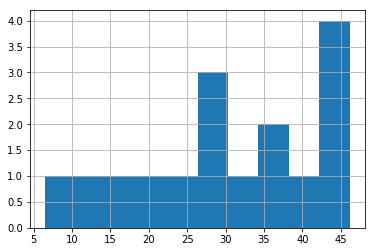

In [16]:
price.hist()

## Run with more data:

### Get more item by set range of page no. 
``` python

lis=p_download.run(range(1,10)

```

### Change search keywords.
it is unable to create nest loop in pipes. we generate all  combination with prodcut function.


``` python 
from  itertools import product

lis=p_download.run(product(range(1,10),['Python','Java','C++'])

                 ```




